## Soluzione esercizio a casa, lezione 2

In [1]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
import numpy as np

In [2]:
def preprocess_data(df: pd.DataFrame) -> gpd.GeoDataFrame:
    houses_df = df.dropna(subset=['LATITUDINE', 'LONGITUDINE', 'PREZZO'])

    # Convert the DataFrame to a GeoDataFrame
    geometry = gpd.points_from_xy(houses_df.LONGITUDINE, houses_df.LATITUDINE)
    houses_gdf = gpd.GeoDataFrame(houses_df, geometry=geometry)
    houses_gdf["geometry"] = houses_gdf["geometry"].set_crs(epsg=4326, inplace=True).to_crs(epsg=3857)
    
    return houses_gdf

def plot_house_prices(houses_gdf: gpd.GeoDataFrame, rioni: gpd.GeoDataFrame):
    fig, ax = plt.subplots()
    
    rioni.plot(ax=ax, color='grey', edgecolor='white', alpha=0.5)
    
    scatter = ax.scatter(
        houses_gdf.geometry.x,
        houses_gdf.geometry.y,
        c=houses_gdf["PREZZO"],
        cmap='RdYlGn_r',
        s=10,
    )
    
    plt.colorbar(scatter, label='Price (€)', format='%.0f')
    
    ax.set_axis_off()
    
    xlim = (houses_gdf.total_bounds[0]*0.99, houses_gdf.total_bounds[2]*1.01)
    ylim = (houses_gdf.total_bounds[1]*0.999, houses_gdf.total_bounds[3]*1.001)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    
    return

In [3]:
rioni = gpd.read_file('../data/Roma_ZU.shp').to_crs(epsg=3857)
df = pd.read_csv('../data/housing.csv')
houses_gdf = preprocess_data(df)

Text(0.5, 1.0, 'Average house prices in Rome neighborhoods')

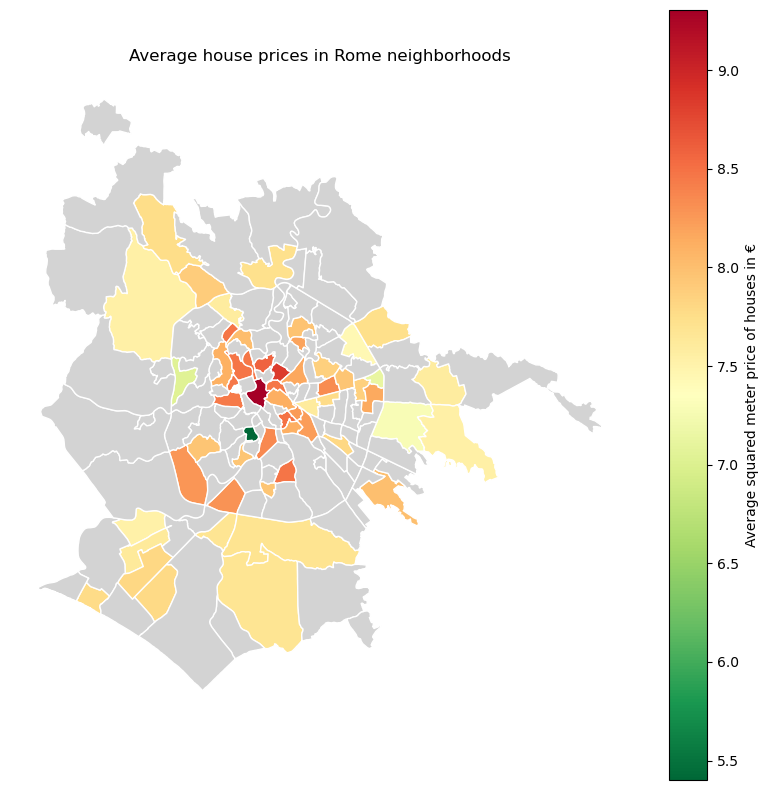

In [5]:

a = gpd.sjoin(houses_gdf, rioni, predicate='within')
a = a[~a.index.duplicated(keep='first')]

# Calculate the price per square meter
houses_gdf["PRICE_M2"] = houses_gdf["PREZZO"] / houses_gdf["SUPERFICIE"]
houses_gdf["rioni"] = a["Name"]

# Calculate the average price per square meter for each neighborhood
rioni_avg_pricem2 = houses_gdf.groupby('rioni')['PRICE_M2'].mean().reset_index()
rioni_avg_pricem2 = rioni_avg_pricem2.rename(columns={'rioni': 'Name', 'PRICE_M2': 'avg_price'})

# Unisci i dati dei rioni con i dati delle case (HINT: usa pd.merge())
rioni_con_prezzo_al_m2 = pd.merge(rioni, rioni_avg_pricem2, on='Name', how='left')

# Create a choropleth map of average house prices in each neighborhood
ax = rioni_con_prezzo_al_m2.plot(
    figsize=(10, 10),
    column=np.log(rioni_con_prezzo_al_m2['avg_price']),
    cmap='RdYlGn_r',
    edgecolor='white',
    legend=True,
    legend_kwds={'label': "Average squared meter price of houses in €"},
    missing_kwds={'color': 'lightgrey'}
)

ax.set_axis_off()
ax.set_title('Average house prices in Rome neighborhoods')